In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz
import os
import datetime
import numpy as np
import torch as th
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
sys.path.append("../classifier/")
from model.data import CGDataset, VectorCGDataset, NeighbourCGDataset
from model.model import DiffCG, MinCutCG, DMoNCG, DeepCG
from run.train import training
from run.test import test


print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 0

dataset_dict = {c.__name__: c for c in {CGDataset, VectorCGDataset, NeighbourCGDataset}}

if vectorize:
    dataset_v = "VectorCGDataset"
elif k > 0:
    dataset_v = "NeighbourCGDataset"
else:
    dataset_v = "CGDataset"

#Training Set
training_dir = "../data/train_set"
rmsd_list = "../data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = dataset_dict[dataset_v](training_dir, rmsd_list, k=k)# T.NormalizeScale()) #, transform=transform_fn

#Validation Set
val_dir = "../data/val_set"
val_rmsd = "../data/val_rmsd_list.txt"
val_dataset = dataset_dict[dataset_v](val_dir, val_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

#Test Data
test_dir = "../data/test_set"
test_rmsd = "../data/test_rmsd_list.txt"
test_dataset = dataset_dict[dataset_v](test_dir, test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "../data/old_training_set"
st_test_rmsd = "../data/old_train_rmsd_list.txt"
st_test_dataset = dataset_dict[dataset_v](st_test_dir, st_test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

#Rotated Test Sets
test_dir_rot = "../data/test_set_rot"
test_rmsd = "../data/test_rmsd_list.txt"
rot_test_dataset = dataset_dict[dataset_v](test_dir_rot, test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

fst_test_rot = "../data/5st_test_rot"
fst_rot_dataset = dataset_dict[dataset_v](fst_test_rot, st_test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

Pytorch Version 1.11.0
Cuda is available: True
Using device: cuda


TODO:
*  Should Vector and Neighbour datasets inherit from CGDataset, to avoid code duplication?
*  Add further that start of s1 is in yz-plane with s0 **Semi-DONE** (theres still a range of angles)
*  are there additional tertiary interactions detected to add?
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  try skip-cat/-sum in layer architecture?
    * use the module `JumpingKnowledge` in PyG

Normalization:
*  BatchNorm: no improvement seen, maybe with larger datasets?
*  PairNorm: Training took longer, results were nonsense
*  DiffGroupNorm: figure out how to configure it (in channels not the same as for the layers)
*  GraphNorm: Strange results, try again. (maybe with GINConv layers, as is shown in the paper?), doesnt seem to work in this case (at least with normal data)
*  LayerNorm: Training took longer, results were worse than without norm
*  InstanceNorm: doesnt work for 3D input? --> try pytorch instancenorm1(?)d instead of pygs

--> try data normalization/standardization (beforehand)

In [2]:
model = MinCutCG(training_dataset.num_node_features)
#model = DeepCG(training_dataset.num_node_features, 48, 16)

05.07.2022 11:13:51 Creating Training Directory at 2022-07-05_11-13_MinCutCG/
05.07.2022 11:13:51 Using CUDNN Benchmark
05.07.2022 11:13:57 Loading Datasets
05.07.2022 11:13:57 Start Training


Epoch 0: Training loss 17.1411; Validation loss 22.1598, MAE: 22.3434; lr: 0.00000
	Add. Loss: Training 0.2489, Validation 0.2443
Epoch 5: Training loss 16.2477; Validation loss 21.2671, MAE: 21.5258; lr: 0.00020
	Add. Loss: Training 0.2379, Validation 0.2336
Epoch 10: Training loss 5.5375; Validation loss 15.3103, MAE: 15.5410; lr: 0.00040
	Add. Loss: Training 0.2606, Validation 0.2572
Epoch 15: Training loss 4.3168; Validation loss 16.2289, MAE: 16.4402; lr: 0.00060
	Add. Loss: Training 0.2705, Validation 0.2870
Epoch 20: Training loss 3.6599; Validation loss 15.7988, MAE: 16.0306; lr: 0.00080
	Add. Loss: Training 0.2559, Validation 0.2571
Epoch 25: Training loss 3.7444; Validation loss 15.6962, MAE: 15.9367; lr: 0.00100
	Add. Loss: Training 0.2513, Validation 0.2506
Epoch 30: Training loss 2.8904; Validation loss 15.7792, MAE: 16.0166; lr: 0.00080
	Add. Loss: Training 0.2503, Validation 0.2500
Epoch 35: Training loss 2.5014; Validation loss 15.4861, MAE: 15.7254; lr: 0.00060
	Add. L

05.07.2022 11:14:47 Training took 0.02 hours
05.07.2022 11:14:47 Minimum Training Loss 1.1208 in epoch 99
05.07.2022 11:14:47 Minimum Validation Loss (after 50 epochs) 14.5557 in epoch 64
05.07.2022 11:14:47 Minimum MAE (after 50 epochs) 14.8056 in epoch 64
05.07.2022 11:14:47 Seed used for training was: 16581638967257361900


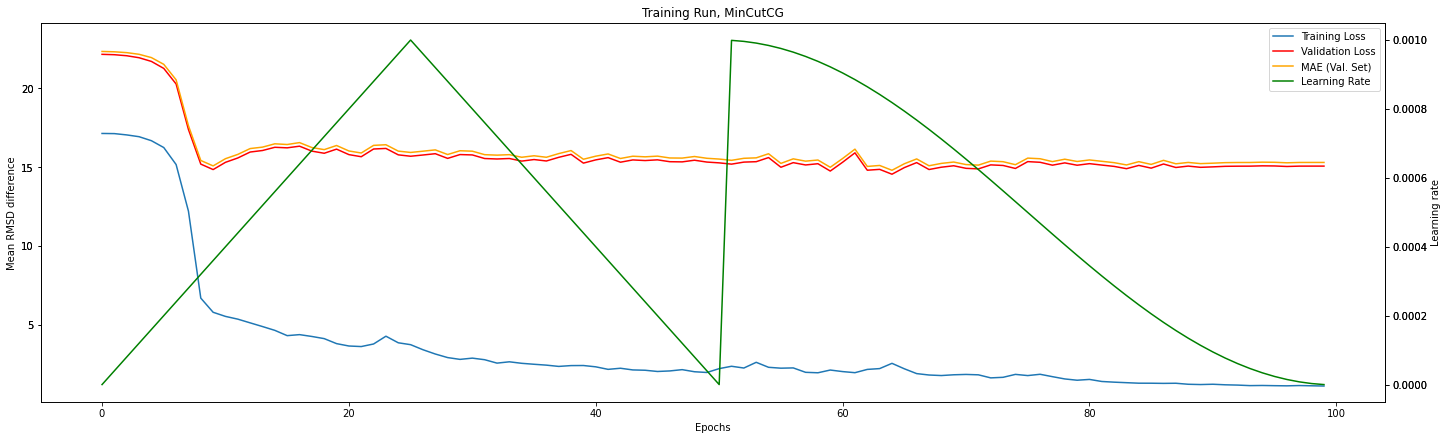

In [3]:
#Training
parent_dir = "../run_data/"

#with th.autograd.detect_anomaly():
training(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=1e-3,
    epochs=100,
    sched_T0=50,
    vectorize=vectorize,
    k=k,
    #num_workers=0,
    #resume="../run_data/2022-07-04_10-2_MinCutCG/model_data/epoch_1999.pth",
    burn_in=50)

In [7]:
#get training run data

run_dir = "../run_data/2022-07-04_12-0_DeepCG"
burn_in = 50

file_lines = []
with open(run_dir + "/loss_data.txt", "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]
epoch_add_losses = [float(d) for d in file_lines[4]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after {burn_in} epochs) {min(val_losses[burn_in:]):.4f} in epoch {val_losses.index(min(val_losses[burn_in:]))}")
print(f"Minimum MAE (after {burn_in} epochs) {min(mae_losses[burn_in:]):.4f} in epoch {mae_losses.index(min(mae_losses[burn_in:]))}")


Minimum Training Loss 0.0449 in epoch 948
Minimum Validation Loss (after 50 epochs) 14.2017 in epoch 953
Minimum MAE (after 50 epochs) 14.6948 in epoch 953


Validation Loss at 953 is 14.2017
5 before select
14.3651, 14.3661, 14.3284, 14.2907, 14.3563
5 after select
14.3072, 14.5469, 14.2484, 14.3752, 14.3063
MAE at 953 is 14.6948


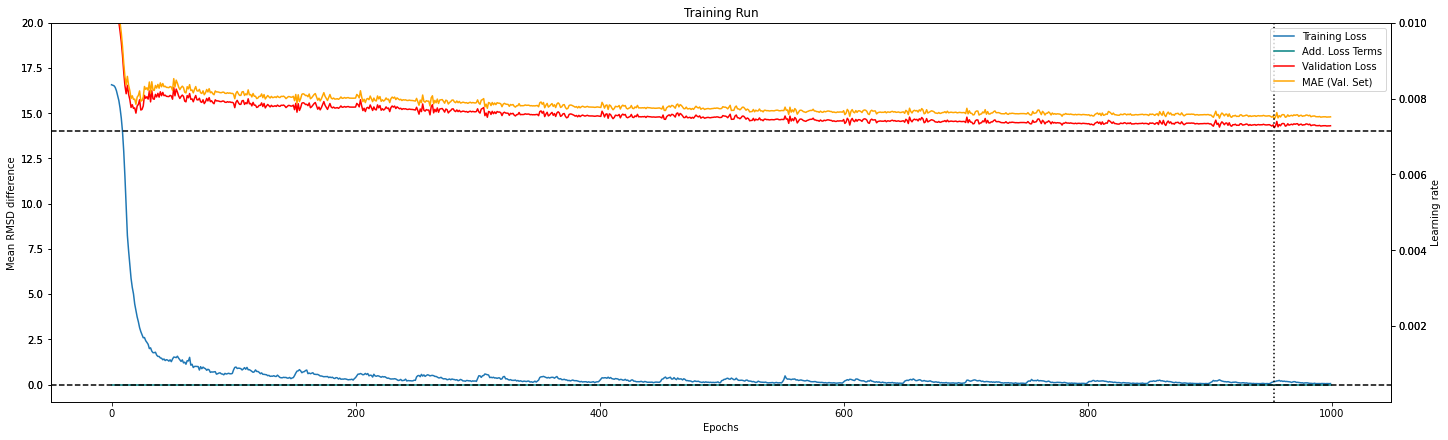

In [8]:
#plot the training run
select = 953

print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(epoch_add_losses, "teal", label="Add. Loss Terms")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")

ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
#ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")

ax1.set_ylim([(min(epoch_losses)-1), 20]) #max(val_losses)+2)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=0, c = "black", ls = "--")
ax1.axhline(y=14, c = "black", ls = "--")

ax2.set_ylim([(min(learning_rates)/10), max(learning_rates)*10])

han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2, loc="upper right")
plt.draw()

Using state dict from epoch 953
Test Set
Minimum Loss: Label = 17.9520, Prediction = 17.9964, Loss = 0.0010
Maximum Loss: Label = 42.3860, Prediction = 15.1100, Loss = 26.7760
Mean Test loss: 	 11.6519
Std. Dev. of Test loss:  6.7951
Min loss: 		 0.0010
First Quantile: 	 6.4054
Median: 		 11.1543
Third Quantile: 	 16.9625
Max Loss: 		 26.7760
LinregressResult(slope=-0.4893258858849245, intercept=26.125474901820105, rvalue=-0.15136845912999358, pvalue=0.011654650798131291, stderr=0.1926917862630979, intercept_stderr=3.7427791234182544)


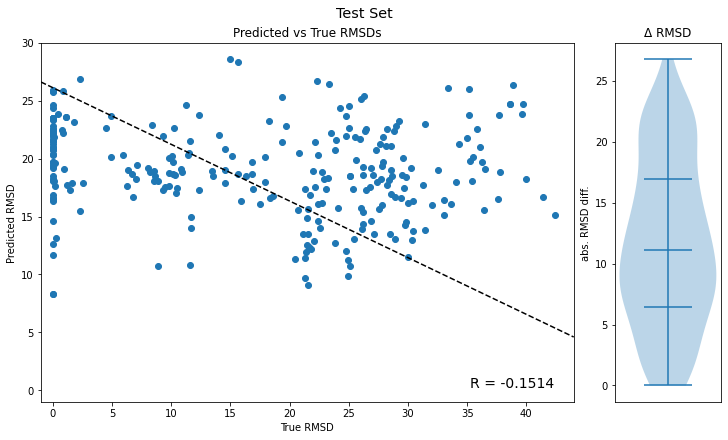

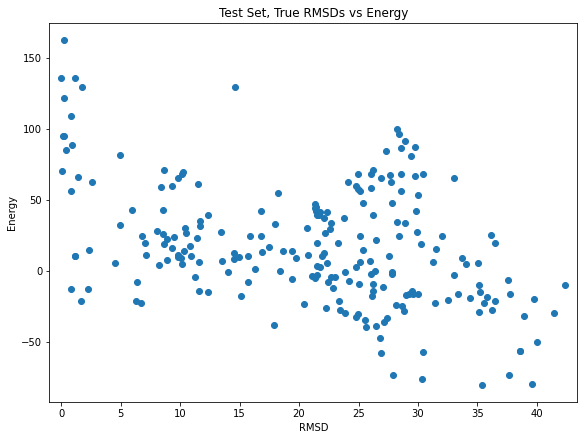

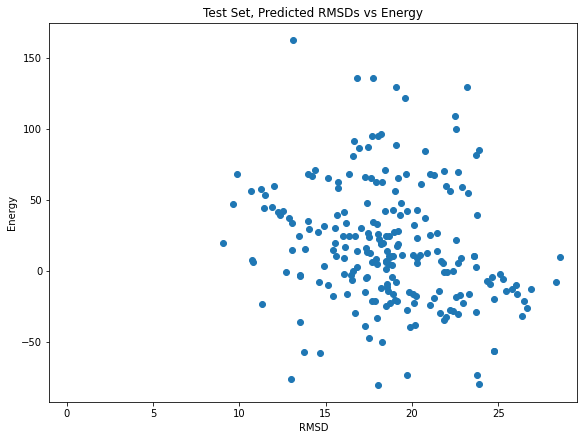

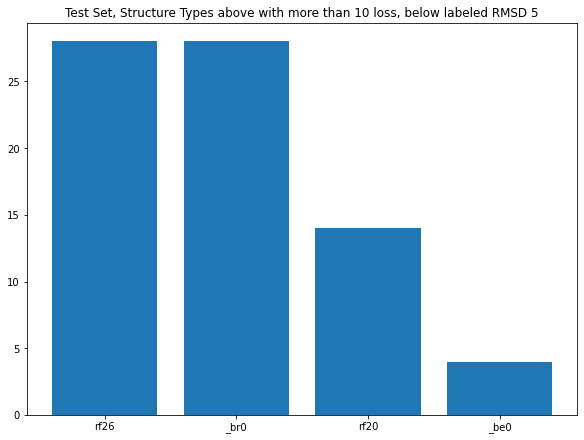

Prediction below 0: Label 0.1490, Pred -0.0168
5S and tRNA Test Set
Minimum Loss: Label = 14.1120, Prediction = 14.0890, Loss = 0.0003
Maximum Loss: Label = 0.0000, Prediction = 23.1367, Loss = 22.6367
Mean Test loss: 	 3.9257
Std. Dev. of Test loss:  4.4129
Min loss: 		 0.0003
First Quantile: 	 0.9060
Median: 		 2.4821
Third Quantile: 	 5.0998
Max Loss: 		 22.6367
LinregressResult(slope=0.9537941986180952, intercept=-0.8947830689348297, rvalue=0.7400262661981157, pvalue=2.0190198633784965e-188, stderr=0.026365580196335718, intercept_stderr=0.4987020327121569)


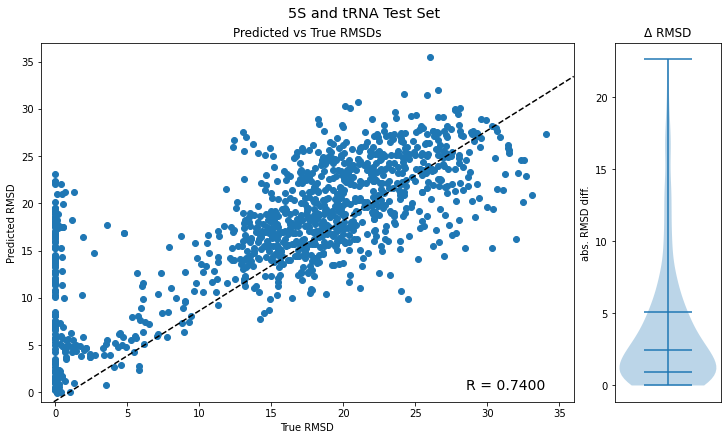

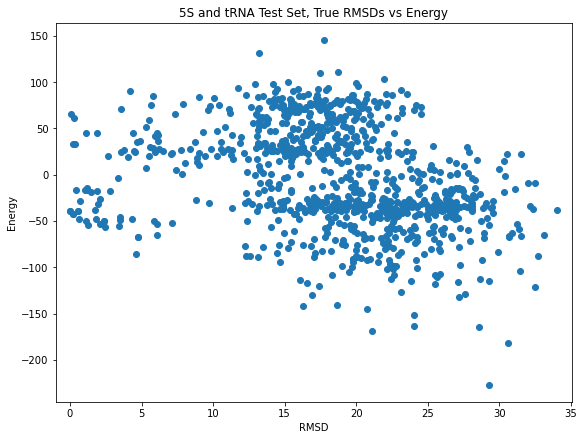

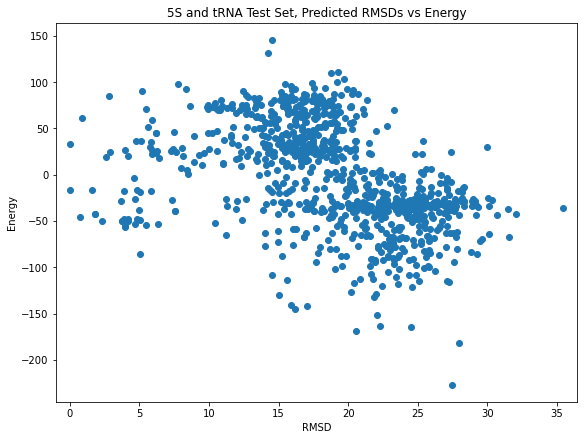

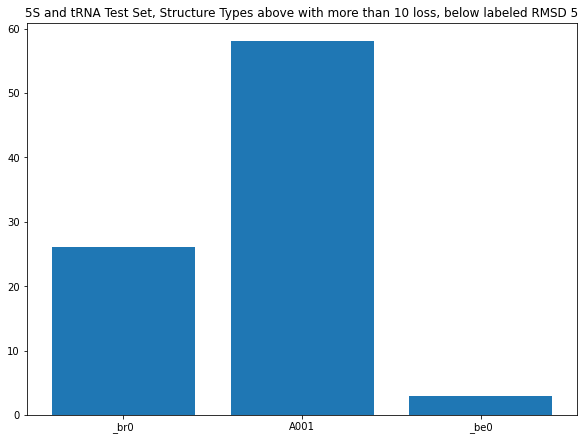

Prediction below 0: Label 0.0000, Pred -0.3522
Prediction below 0: Label 0.7560, Pred -0.4609
Prediction below 0: Label 0.0000, Pred -0.3522
Prediction below 0: Label 0.0000, Pred -0.3522
Prediction below 0: Label 0.1680, Pred -0.5850
Prediction below 0: Label 0.0000, Pred -0.4375
Prediction below 0: Label 0.0000, Pred -0.7208
Prediction below 0: Label 0.0000, Pred -0.4375
Prediction below 0: Label 0.6890, Pred -0.4307
Prediction below 0: Label 0.0000, Pred -0.4375
Prediction below 0: Label 0.1680, Pred -0.5850
Prediction below 0: Label 0.0140, Pred -0.7226
Training Set
Minimum Loss: Label = 27.8510, Prediction = 27.8511, Loss = 0.0000
Maximum Loss: Label = 19.9530, Prediction = 22.1351, Loss = 1.6821
Mean Test loss: 	 0.1330
Std. Dev. of Test loss:  0.2065
Min loss: 		 0.0000
First Quantile: 	 0.0096
Median: 		 0.0486
Third Quantile: 	 0.1677
Max Loss: 		 1.6821
LinregressResult(slope=0.9829494554931522, intercept=0.09908524301046029, rvalue=0.9988667364666856, pvalue=0.0, stderr=0.00

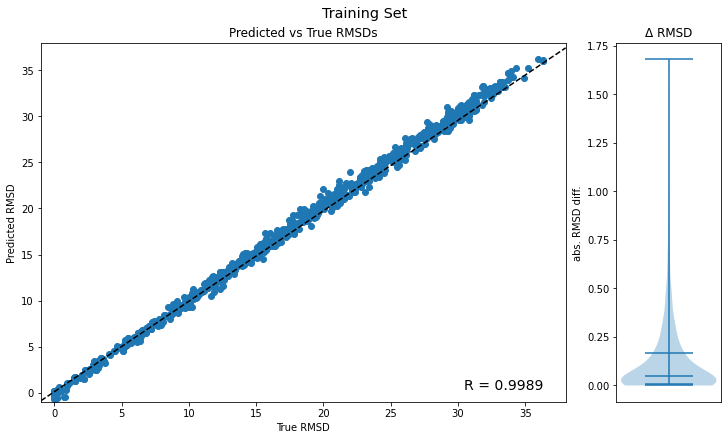

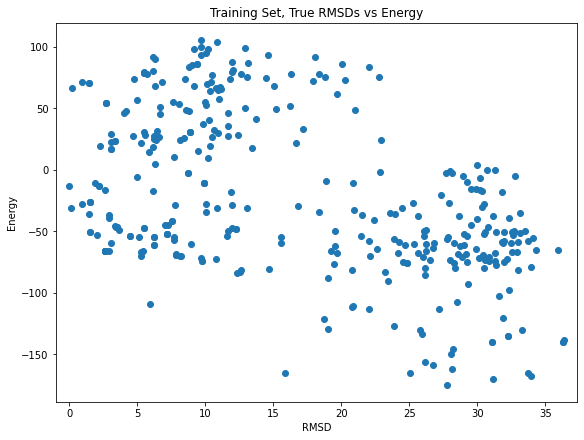

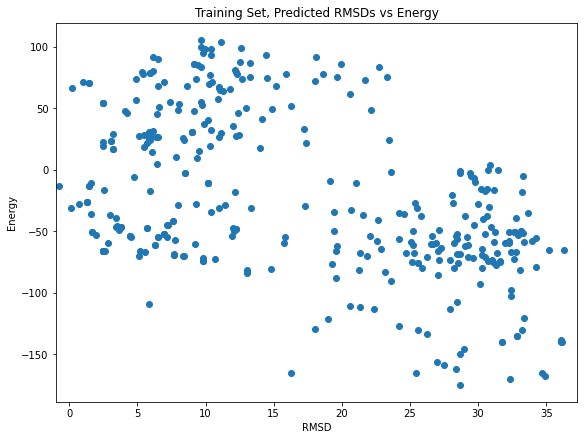

Validation Set
Minimum Loss: Label = 21.5350, Prediction = 21.4559, Loss = 0.0031
Maximum Loss: Label = 61.9850, Prediction = 16.1841, Loss = 45.3009
Mean Test loss: 	 13.9105
Std. Dev. of Test loss:  10.3528
Min loss: 		 0.0031
First Quantile: 	 5.3260
Median: 		 12.1930
Third Quantile: 	 21.3557
Max Loss: 		 45.3009
LinregressResult(slope=-0.2782703846372756, intercept=29.188752917592755, rvalue=-0.10210808822020483, pvalue=0.04227399692722453, stderr=0.13657866300716015, intercept_stderr=3.0259024715430844)


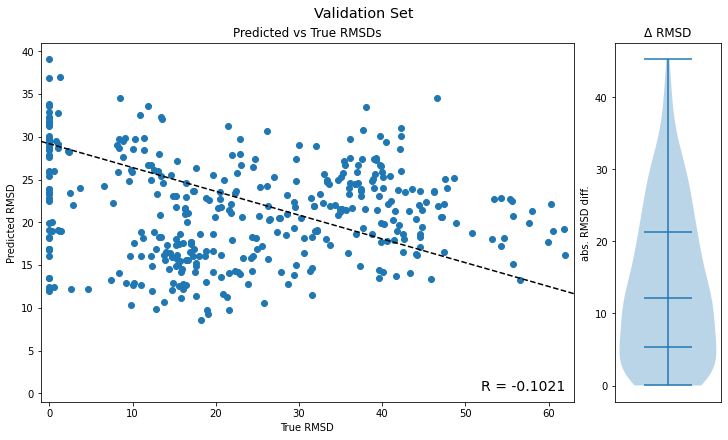

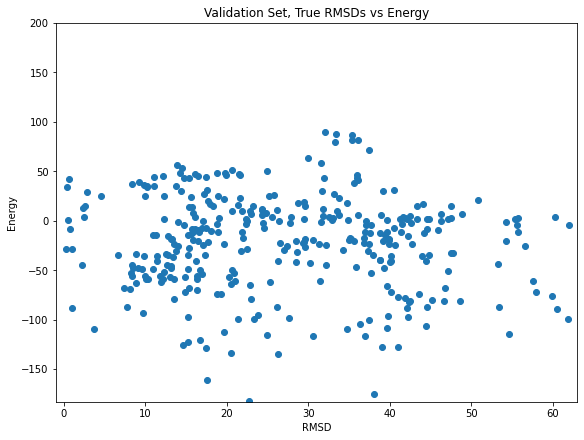

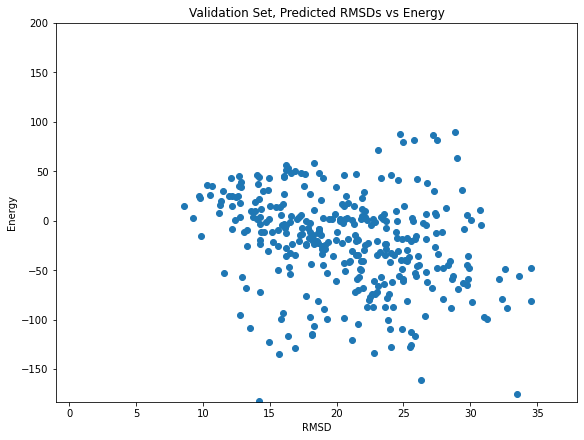

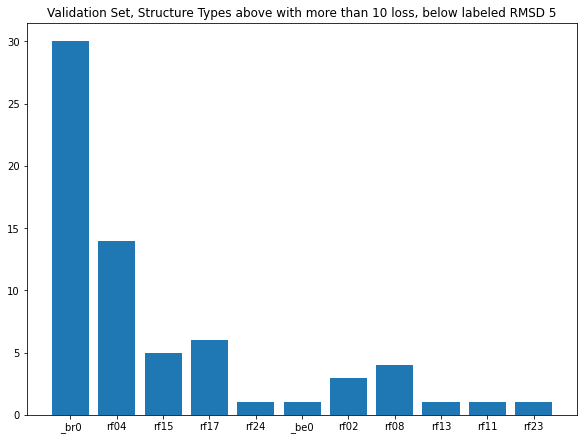

LinregressResult(slope=0.6574901136661101, intercept=8.114601701103242, rvalue=0.36964860637004293, pvalue=1.740451783285575e-49, stderr=0.04283006599028124, intercept_stderr=0.8626681130967216)


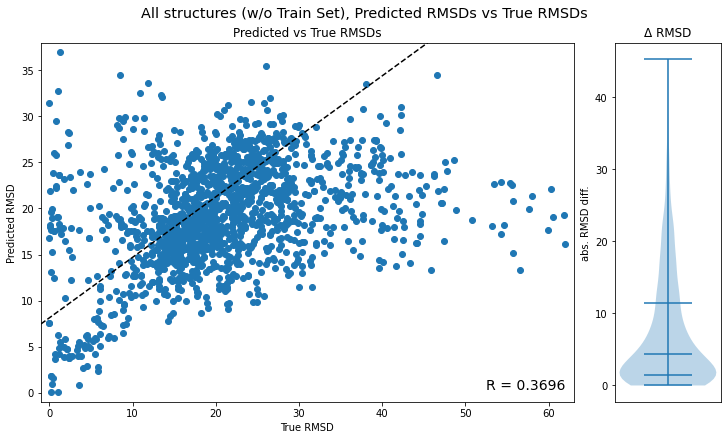

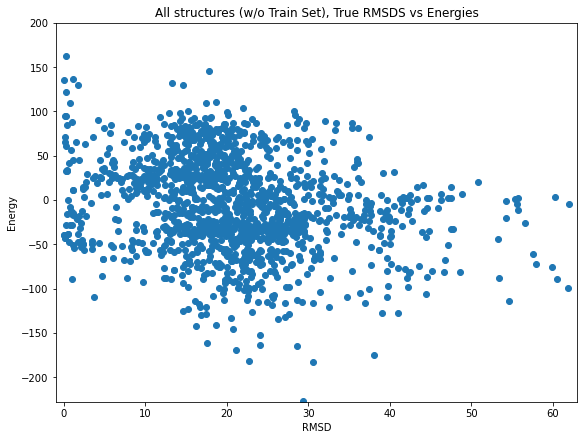

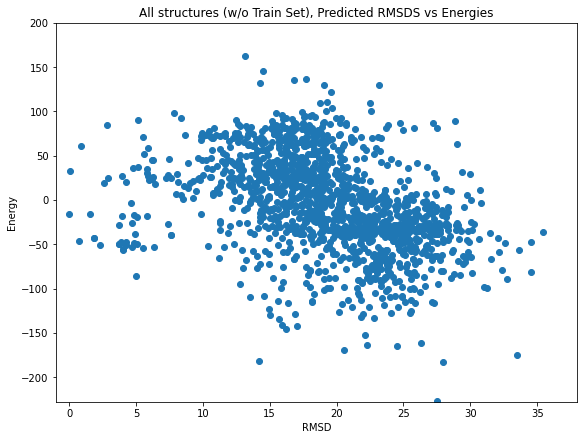

In [9]:
#Test
from run.utility import get_energy_dict, rmsd_scatter, e_rmsd_scatter

# loss cutoff for type histo
cutoff = [10, 5]

train_loader = DataLoader(training_dataset, batch_size=1)
val_loader = DataLoader(val_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)
st_test_dataloader = DataLoader(st_test_dataset, batch_size=1)

model.to(device)
checkpoint = th.load(f"{run_dir}/model_data/epoch_{select}.pth")
print(f"Using state dict from epoch {checkpoint['epoch']}")
model.load_state_dict(checkpoint["model_state_dict"])

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("../data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("../data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("../data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("../data/val_energy.txt")
    en, trs, prs, tlosses = test(model, loader, e_dict, title, device, cutoff)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

        

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=0.9091579813203675, intercept=1.8185265564939073, rvalue=0.9366382501401529, pvalue=2.694587713881415e-127, stderr=0.020504017003080147, intercept_stderr=0.40753690556040806)


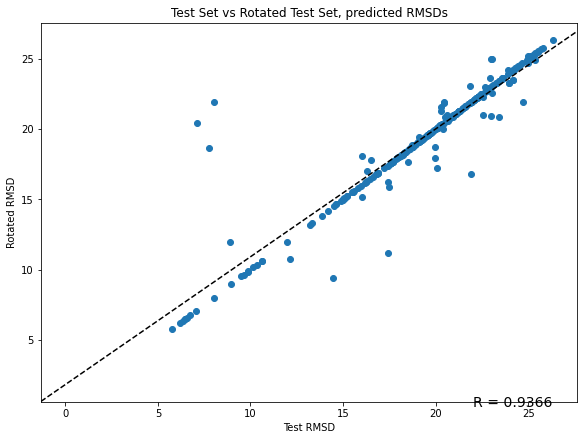

LinregressResult(slope=0.9786476636103387, intercept=0.3422918149869716, rvalue=0.9785232101141297, pvalue=1.2132055836684666e-190, stderr=0.012432089962595764, intercept_stderr=0.168440886827594)


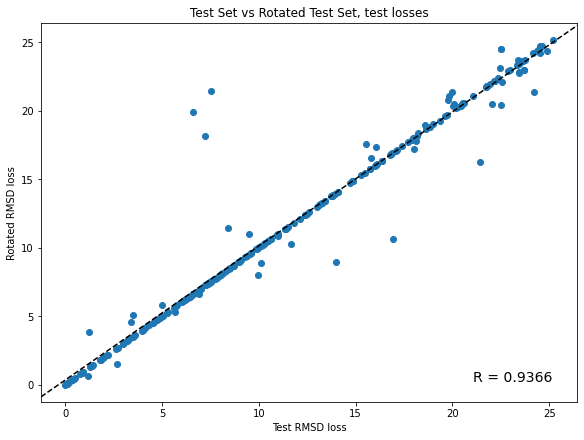

LinregressResult(slope=0.9712626165796127, intercept=0.5077173948013183, rvalue=0.9651781637725774, pvalue=0.0, stderr=0.00800650792132218, intercept_stderr=0.15077171482414378)


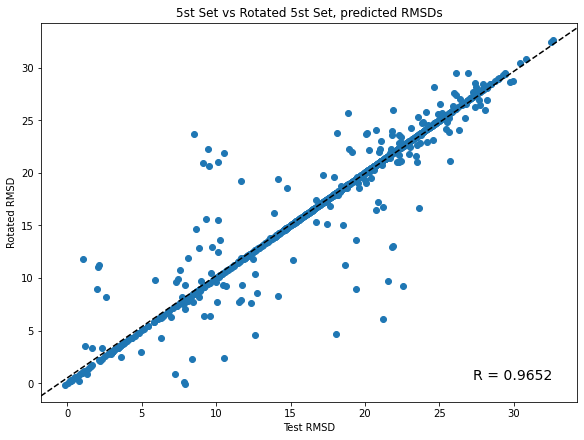

LinregressResult(slope=0.9253551594236874, intercept=0.29146281014302033, rvalue=0.9308669272310164, pvalue=0.0, stderr=0.011046561261775974, intercept_stderr=0.07107113242709055)


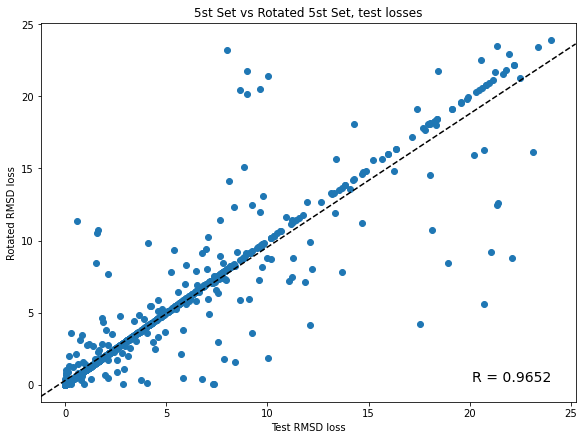

In [20]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")